In [1]:
from pathlib import Path
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
filter = [ "pluginAssetId", "assetId","interactionName" ]
keys = ["1732777549872288573", "5984175597303660107", "call PZN"]
config_id = "fciPluginAppInteractions"

# the below value filling should be closer to when the incident happens. We fetch 11 days of data. Train on first 10 days of data and the 11th and 12th day where incident happened we try to simulate inference and see scores.

from fakeredis import FakeStrictRedis, FakeServer
from numalogic.udfs import PipelineConf
import os
from omegaconf import OmegaConf

plt.rcParams["figure.figsize"] = (20,3)
conf_1 = OmegaConf.load(os.path.join(Path(os.getcwd()).parent.absolute(), 'experiment_config.yaml'))
schema = OmegaConf.structured(PipelineConf)
conf = OmegaConf.merge(schema, conf_1)
pl_conf = PipelineConf(**OmegaConf.merge(schema, conf_1))
input_features = ['failed', 'degraded']
REDIS_CLIENT = FakeStrictRedis(server=FakeServer())

import logging
logging.basicConfig(level = logging.INFO)
import pandas as pd

from helper import data_fetch, _construct_clf, get_feature_arr, ModifiedDruidTrainerUDF

In [2]:
file_name = 'e328876187b08290084b4197cebb357a.csv'
raw_file_name = "raw_df.csv"
data = pd.read_csv(file_name)
print("************************")
print(data['pluginassetid'].value_counts())
print("************************")
print(data['assetid'].value_counts())
print("************************")
print(data['interactionname'].value_counts())
data.rename(columns={'eventdatetime': 'timestamp', 'cistatus': 'ciStatus', 'interactionname': 'interactionName', 'assetid': "assetId", 'pluginassetid': "pluginAssetId"}, inplace =True)
data['pluginAssetId'] = data['pluginAssetId'].astype(str)
data['assetId']=data['assetId'].astype(str)
for i in range(len(filter)):
    data = data[data[filter[i]]==keys[i]]
data.to_csv(raw_file_name, index=None)
data

************************
pluginassetid
1732777549872288573    25910
Name: count, dtype: int64
************************
assetid
5984175597303660107    25910
Name: count, dtype: int64
************************
interactionname
renderGeneralSettingsSection              10346
renderSetupUpKioskStep                    10208
renderIntentPickerStep                     1348
saveIntentPickerSelection                   945
renderPreferencesSettingsStep               602
renderInviteTeamStep                        573
saveFieldSettingsSelection                  565
renderFieldSettingsStep                     477
savePreferencesSettingsSelection            413
renderFieldSettings                         259
updateTimeItmTasksToComplete                 90
updateTimesheetFirstDayOfWorkWeek            69
updateKioskTaskStatusAfterAddingKiosks       15
Name: count, dtype: int64


,eventid,assetId,assetalias,timestamp,ciStatus,env,interactionName,pluginassetalias,pluginAssetId,count,assettype,eb_time


In [3]:
_out = data_fetch(filter= filter, keys = keys, file_name = raw_file_name)
_out["timestamp"]  = pd.to_datetime(_out['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')
_out.set_index('timestamp', inplace = True)
train = _out.iloc[:-2*24*60,:]
test = _out.iloc[-24*60*2:,:]
train.to_csv(str(file_name)+'-train.csv', index= None)
test.to_csv(str(file_name)+'-test.csv', index= None)

KeyError: 'timestamp'

In [5]:
train.plot()

NameError: name 'train' is not defined

In [6]:
test.plot()

NameError: name 'test' is not defined

In [7]:
from numalogic.udfs import PreprocessUDF, PostprocessUDF, InferenceUDF

preproc_udf= PreprocessUDF(REDIS_CLIENT, pl_conf=pl_conf)
_stream_conf = preproc_udf.get_stream_conf(config_id)
_conf = _stream_conf.ml_pipelines["metrics"]
inference_udf= InferenceUDF(REDIS_CLIENT, pl_conf=pl_conf)
postproc_udf= PostprocessUDF(REDIS_CLIENT, pl_conf=pl_conf)
trainer_udf = ModifiedDruidTrainerUDF(REDIS_CLIENT, pl_conf=pl_conf, file =file_name)

# TRAINER

In [8]:
from torchinfo import summary
from numalogic.config import ModelFactory, ThresholdFactory

preproc_clf = _construct_clf(_conf.numalogic_conf.preprocess)
trainer_transform = _construct_clf(_conf.numalogic_conf.trainer.transforms)
model = ModelFactory().get_instance(_conf.numalogic_conf.model)
thresh_clf = ThresholdFactory().get_instance(_conf.numalogic_conf.threshold)
print(summary(model))   
data,_,_= get_feature_arr(train, metrics=input_features)
artifact, train_reconerr = trainer_udf.compute(model = model,input_=data ,preproc_clf=preproc_clf, trainer_transform=trainer_transform,threshold_clf=thresh_clf, numalogic_cfg=_conf.numalogic_conf)

Layer (type:depth-idx)                   Param #
VanillaAE                                --
├─_Encoder: 1-1                          --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  336
│    │    └─BatchNorm1d: 3-2             2
│    │    └─Tanh: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─Linear: 3-5                  136
│    │    └─BatchNorm1d: 3-6             2
│    │    └─ReLU: 3-7                    --
├─_Decoder: 1-2                          --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-8                  144
│    │    └─BatchNorm1d: 3-9             2
│    │    └─Tanh: 3-10                   --
│    │    └─Dropout: 3-11                --
│    │    └─Linear: 3-12                 340
Total params: 962
Trainable params: 962
Non-trainable params: 0


NameError: name 'train' is not defined

<Axes: >

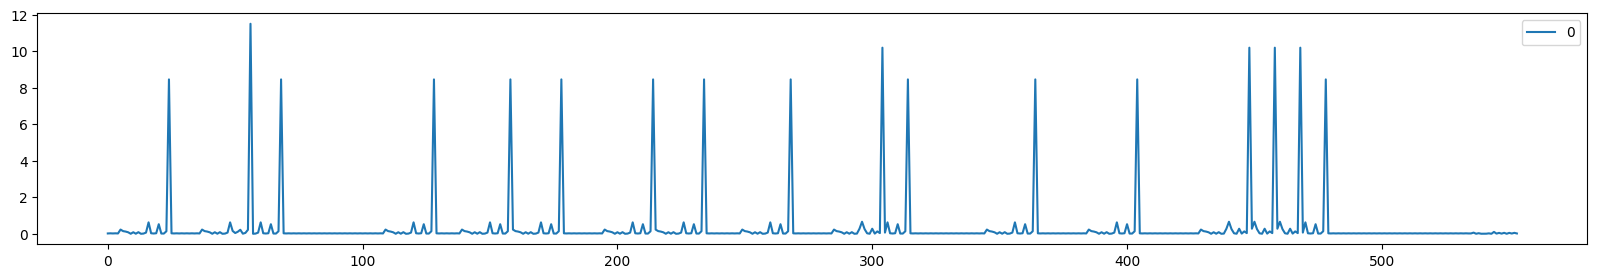

In [12]:
pd.DataFrame(train_reconerr).plot()

# INFERENCE PL

In [13]:
from numalogic.tools.data import StreamingDataset

test_data ,_,_= get_feature_arr(test, metrics=input_features)
ds = StreamingDataset(test_data, seq_len=pl_conf.stream_confs[config_id].window_size)

/Users/kbatra/home/public-Code/lol/numalogic/numalogic/osam-backtest/INC1792740/helper.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df[col] = fill_value


In [14]:
artifact

{'preproc_clf': KeyedArtifact(dkeys=['StandardScaler', 'FlattenVector'], artifact=Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('flattenvector',
                  <numalogic.transforms._stateless.FlattenVector object at 0x14225f290>)]), stateful=True),
 'inference': KeyedArtifact(dkeys=['VanillaAE'], artifact=VanillaAE(
   (encoder): _Encoder(
     (encoder): Sequential(
       (0): Linear(in_features=20, out_features=16, bias=True)
       (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): Tanh()
       (3): Dropout(p=0.25, inplace=False)
       (4): Linear(in_features=16, out_features=8, bias=True)
       (5): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (6): ReLU()
     )
   )
   (decoder): _Decoder(
     (decoder): Sequential(
       (0): Linear(in_features=8, out_features=16, bias=True)
       (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [15]:
from numalogic.config import PostprocessFactory, ScoreConf

preproc_clf = artifact['preproc_clf'].artifact
model = artifact['inference'].artifact
thresh_clf = artifact['threshold_clf'].artifact
postproc_tx = PostprocessFactory().get_instance(_conf.numalogic_conf.postprocess)
score = []
infer_score = []
for arr in ds:
    preproc_data = preproc_clf.transform(arr)
    infer_data  = inference_udf.compute(model = model, input_ =preproc_data)
    infer_score.append(infer_data.mean())
    postproc_data = postproc_udf.compute(model = thresh_clf, input_ =infer_data, postproc_tx=postproc_tx, score_conf=ScoreConf()) 
    score.append(postproc_data.mean())

# Final Anomaly Score for the window

<Axes: xlabel='timestamp'>

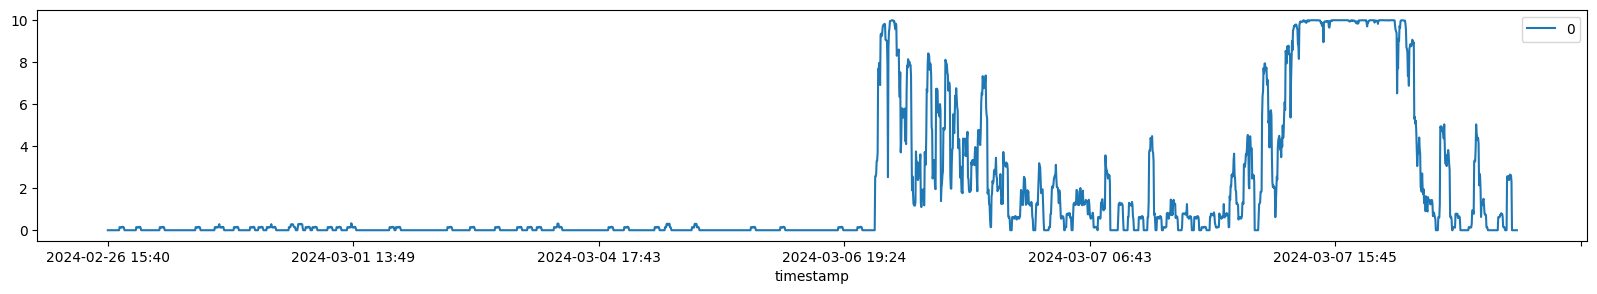

In [16]:
import pandas as pd

pd.DataFrame(score, index=test[9:].index).plot()

# Failed metrics during the incident time

<Axes: xlabel='timestamp'>

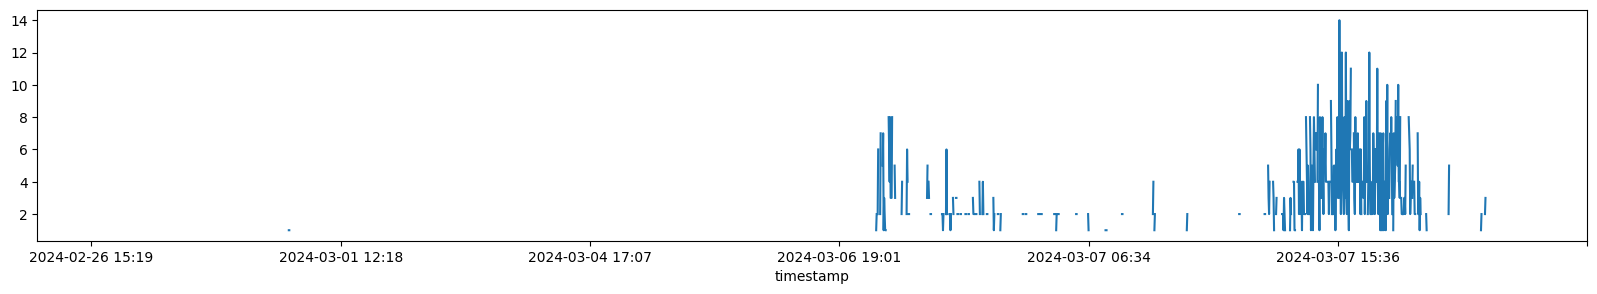

In [17]:
test['failed'].plot()

# Degraded metrics during the incident time

<Axes: xlabel='timestamp'>

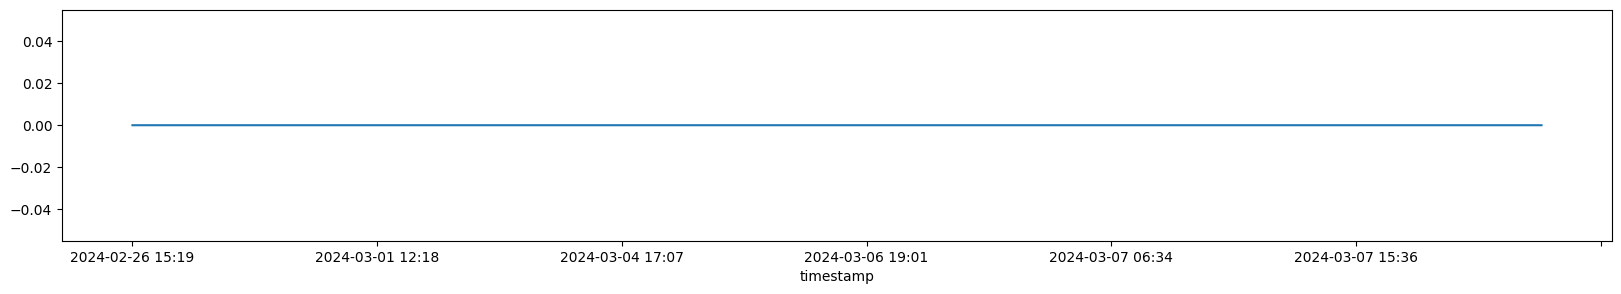

In [18]:
test['degraded'].plot()